<a href="https://colab.research.google.com/github/iamviji/project/blob/master/misc/PyLDPC_CommPy_ITPP_BER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
!git clone https://github.com/veeresht/CommPy.git
import sys
sys.path.append('./CommPy')

fatal: destination path 'CommPy' already exists and is not an empty directory.


In [123]:
import commpy.channels as chan
import commpy.modulation as mod
import commpy.utilities as util
!pip install pyldpc

In [124]:
import pyldpc
import numpy 
import time


In [156]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 8
num_bits_in_parity_check = 9 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [157]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message



In [158]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 9 channel_size= 18
input_message_size= 9 channel_size= 18
[[0 1 0 ... 0 1 0]
 [0 0 1 ... 0 1 0]
 [0 1 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 0]]


In [159]:
import commpy
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)    
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_pyldpc=numpy.append(bler_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 4.90s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 9.98s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 14.77s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 19.85s
SNR: 0.000:
 -> BER: 0.64
 -> Total Time: 49.50s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 4.45s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 9.23s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 13.55s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 17.75s
SNR: 0.500:
 -> BER: 0.58
 -> Total Time: 44.98s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 3.78s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 7.44s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 11.61s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 15.46s
SNR: 1.000:
 -> BER: 0.48
 -> Total Time: 38.29s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 3.18s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 6.14s
SNR: 1.500 - Iter: 750 - Last 25

In [160]:
modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_commpy_psk_2  = numpy.array(())
times_per_iter_pyldpc_commpy_psk_2= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_pyldpc_commpy_psk_2=numpy.append(bler_per_iter_pyldpc_commpy_psk_2 ,ber)
  times_per_iter_pyldpc_commpy_psk_2=numpy.append(times_per_iter_pyldpc_commpy_psk_2, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 4.60s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 8.92s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 13.39s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 17.85s
SNR: 0.000:
 -> BER: 0.53
 -> Total Time: 44.75s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 4.10s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 8.42s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 12.73s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 17.03s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 42.28s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 3.67s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 7.63s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 11.65s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 15.49s
SNR: 1.000:
 -> BER: 0.43
 -> Total Time: 38.44s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 3.57s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 6.83s
SNR: 1.500 - Iter: 750 - Last 25

In [161]:
modem = mod.PSKModem(4) #QPSK
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_commpy_psk_4  = numpy.array(())
times_per_iter_pyldpc_commpy_psk_4= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_pyldpc_commpy_psk_4=numpy.append(bler_per_iter_pyldpc_commpy_psk_4 ,ber)
  times_per_iter_pyldpc_commpy_psk_4=numpy.append(times_per_iter_pyldpc_commpy_psk_4, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 5.61s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 11.18s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 16.70s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 22.37s
SNR: 0.000:
 -> BER: 0.81
 -> Total Time: 55.86s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 5.51s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 11.10s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 16.45s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 21.89s
SNR: 0.500:
 -> BER: 0.77
 -> Total Time: 54.95s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 5.40s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 10.69s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 16.33s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 21.51s
SNR: 1.000:
 -> BER: 0.72
 -> Total Time: 53.93s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 5.33s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 10.48s
SNR: 1.500 - Iter: 750 - Las

In [165]:
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,9))

modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_2  = numpy.array(())
times_per_iter_uncoded_commpy_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message_uncoded[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_commpy_psk_2=numpy.append(bler_per_iter_uncoded_commpy_psk_2 ,ber)
  times_per_iter_uncoded_commpy_psk_2=numpy.append(times_per_iter_uncoded_commpy_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.000:
 -> BER: 0.57
 -> Total Time: 0.44s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.500:
 -> BER: 0.46
 -> Total Time: 0.43s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.12s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.16s
SNR: 1.000:
 -> BER: 0.41
 -> Total Time: 0.40s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [163]:
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,10))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_commpy_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message_uncoded[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_commpy_psk_4=numpy.append(bler_per_iter_uncoded_commpy_psk_4 ,ber)
  times_per_iter_uncoded_commpy_psk_4=numpy.append(times_per_iter_uncoded_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.12s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.16s
SNR: 0.000:
 -> BER: 0.81
 -> Total Time: 0.41s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.15s
SNR: 0.500:
 -> BER: 0.79
 -> Total Time: 0.38s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.15s
SNR: 1.000:
 -> BER: 0.77
 -> Total Time: 0.36s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

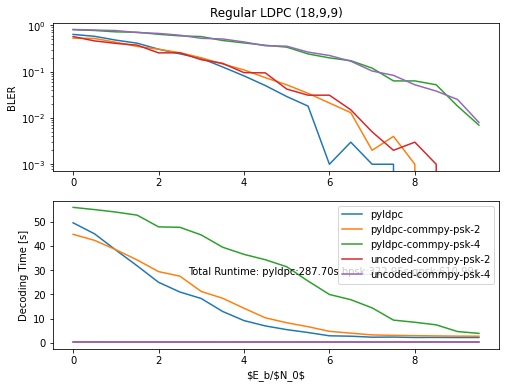

In [166]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_uncoded_commpy_psk_2,'', label="uncoded-commpy-psk-2") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_pyldpc_commpy_psk_2), numpy.sum(times_per_iter_pyldpc_commpy_psk_4)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [134]:
!sudo apt-get install autoconf
!sudo apt-get install libtool
!sudo apt-get install liblapack-dev libblas-dev libfftw3-dev
!rm -rf itpp
!git clone https://github.com/iamviji/itpp.git # original one had compilation issue, did minor signle line change after forking
!ls;cd itpp;ls;mkdir -p build1 build2; cd build1 ; cmake cmake ..;make ;make install
!rm -rf py-itpp
!git clone https://github.com/vidits-kth/py-itpp.git
!pip3 install pybind11
!cd py-itpp;./install_prerequisites_python3.sh;make install;pip3 install -e .  
!cd py-itpp; ls ; pip3 install -e .  
!cat py-itpp/setup.py
import sys
!cp -rf py-itpp/lib/itpp py-itpp/lib/pyitpp # import itpp is not working, after this hack i started to work
sys.path.append('./py-itpp/lib')
#!pip install gwpy &> /dev/null

Reading package lists... Done
Building dependency tree       
Reading state information... Done
autoconf is already the newest version (2.69-11).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtool is already the newest version (2.4.6-2).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libblas-dev is already the newest version (3.7.1-4ubuntu1).
libfftw3-dev is already the newest version (3.3.7-1).
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Cloning into 'itpp'...
remote: Enumerating objects: 14431, done.
remote: Total 14431 (delta 0), reused 0 (delta 0), pack-reused 14431
Receiving objects: 100% (14431/14431), 4.88 MiB | 6.83 MiB/s, done.
Resolving deltas: 100% (12154/12154), done.

In [135]:
import pyitpp as itpp
from matplotlib import pyplot as plt

In [167]:
nrof_bits = 9
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_2  = numpy.array(())
times_per_iter_uncoded_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_2=numpy.append(bler_per_iter_uncoded_itpp_psk_2 ,ber)
  times_per_iter_uncoded_itpp_psk_2=numpy.append(times_per_iter_uncoded_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.000:
 -> BER: 0.49
 -> Total Time: 0.06s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.46
 -> Total Time: 0.05s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.41
 -> Total Time: 0.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [168]:
nrof_bits = 9
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_bpsk  = numpy.array(())
times_per_iter_uncoded_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_bpsk=numpy.append(bler_per_iter_uncoded_itpp_bpsk ,ber)
  times_per_iter_uncoded_itpp_bpsk=numpy.append(times_per_iter_uncoded_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.000:
 -> BER: 0.79
 -> Total Time: 0.05s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.76
 -> Total Time: 0.04s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.71
 -> Total Time: 0.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [169]:
nrof_bits = 10
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_4  = numpy.array(())
times_per_iter_uncoded_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_4=numpy.append(bler_per_iter_uncoded_itpp_psk_4 ,ber)
  times_per_iter_uncoded_itpp_psk_4=numpy.append(times_per_iter_uncoded_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.000:
 -> BER: 0.82
 -> Total Time: 0.06s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.81
 -> Total Time: 0.05s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.74
 -> Total Time: 0.05s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

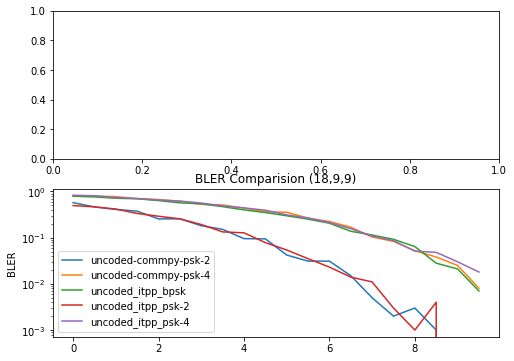

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="uncoded_itpp_bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [171]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_bpsk  = numpy.array(())
times_per_iter_ham_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_bpsk=numpy.append(bler_per_iter_ham_itpp_bpsk ,ber)
  times_per_iter_ham_itpp_bpsk=numpy.append(times_per_iter_ham_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BER: 0.53
 -> Total Time: 0.09s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.500:
 -> BER: 0.48
 -> Total Time: 0.09s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 1.000:
 -> BER: 0.40
 -> Total Time: 0.09s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [172]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_2  = numpy.array(())
times_per_iter_ham_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_psk_2=numpy.append(bler_per_iter_ham_itpp_psk_2 ,ber)
  times_per_iter_ham_itpp_psk_2=numpy.append(times_per_iter_ham_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BER: 0.20
 -> Total Time: 0.10s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.500:
 -> BER: 0.15
 -> Total Time: 0.11s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 1.000:
 -> BER: 0.11
 -> Total Time: 0.09s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [173]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_4  = numpy.array(())
times_per_iter_ham_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    #print ("x")
    #print (source_bits)
    encoded_bits = hamm.encode(source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    #print (demodulated_bits)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_psk_4=numpy.append(bler_per_iter_ham_itpp_psk_4 ,ber)
  times_per_iter_ham_itpp_psk_4=numpy.append(times_per_iter_ham_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BER: 0.54
 -> Total Time: 0.09s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.500:
 -> BER: 0.46
 -> Total Time: 0.10s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 0.08s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

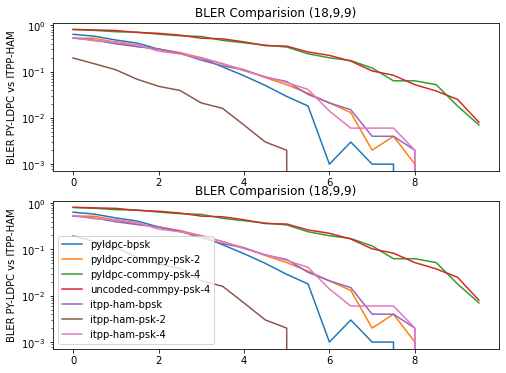

In [175]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [176]:
import numpy
def bit_error_ratio_uncoded_awgn_bpsk(snr_db):
  
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_bpsk_c(snr_db):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK_c()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_xxx(snr_db, n):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.PSK(n)
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

'''SNR range'''
snrs_db = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)

print('BER Started')
ber_itpp_uncoded_bpsk = [bit_error_ratio_uncoded_awgn_bpsk(snr) for snr in snrs_db]
ber_itpp_uncoded_bpsk_c = [bit_error_ratio_uncoded_awgn_bpsk_c(snr) for snr in snrs_db]
ber_itpp_uncoded_psk_2 = [bit_error_ratio_uncoded_awgn_xxx(snr, 2) for snr in snrs_db]
ber_itpp_uncoded_psk_4 = [bit_error_ratio_uncoded_awgn_xxx(snr, 4) for snr in snrs_db]
ber_itpp_uncoded_psk_8 = [bit_error_ratio_uncoded_awgn_xxx(snr, 8) for snr in snrs_db]
ber_itpp_uncoded_psk_16 = [bit_error_ratio_uncoded_awgn_xxx(snr, 16) for snr in snrs_db]
print('BER Finished')

BER Started
BER Finished


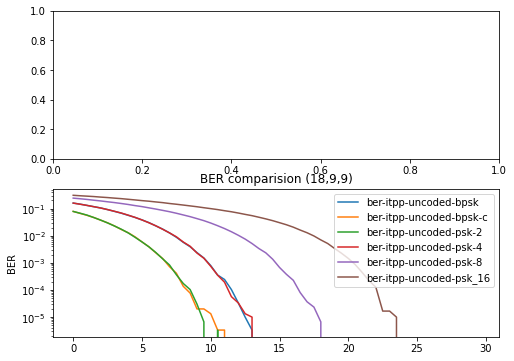

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk,'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk_c,'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_2,'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_4,'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_8,'', label="ber-itpp-uncoded-psk-8") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_16,'', label="ber-itpp-uncoded-psk_16") # plot BER vs SNR
ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

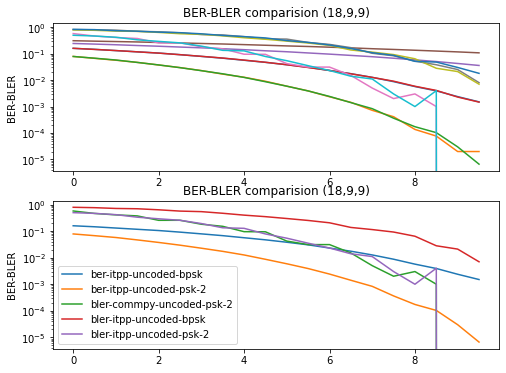

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_itpp_uncoded_bpsk[0:20],'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_bpsk_c[0:20],'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_2[0:20],'', label="ber-itpp-uncoded-psk_2") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_4[0:20],'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_8[0:20],'', label="ber-itpp-uncoded-psk-8") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_16[0:20],'', label="ber-itpp-uncoded-psk-16") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-commpy-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="bler-commpy-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="bler-itpp-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="bler-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.set_ylabel('BER-BLER')
ax1.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax1.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
ax2.semilogy(snrs,ber_itpp_uncoded_bpsk[0:20],'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,ber_itpp_uncoded_psk_2[0:20],'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_qpsk[0:20],'', label="ber_unc_qpsk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_8psk[0:20],'', label="ber_unc_8psk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_16psk[0:20],'', label="ber_unc_16psk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-commpy-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-uncoded-qpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="bler-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax2.set_ylabel('BER-BLER')
ax2.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

No Bit Errors :)
No Bit Errors :)
No Bit Errors :)


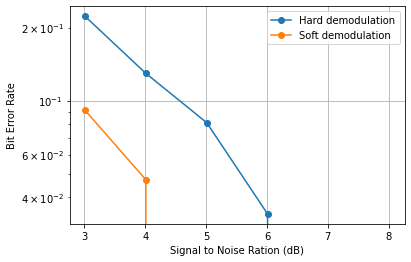

In [181]:
#https://github.com/veeresht/CommPy/blob/master/commpy/examples/conv_encode_decode.py
# Authors: CommPy contributors
# License: BSD 3-Clause

from __future__ import division, print_function  # Python 2 compatibility

import math

import matplotlib.pyplot as plt
import numpy as np

import commpy.channelcoding.convcode as cc
import commpy.channels as chan
import commpy.links as lk
import commpy.modulation as mod
import commpy.utilities as util

# =============================================================================
# Convolutional Code 1: G(D) = [1+D^2, 1+D+D^2]
# Standard code with rate 1/2
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array(2, ndmin=1)

# Generator matrix
g_matrix = np.array((0o5, 0o7), ndmin=2)

# Create trellis data structure
trellis1 = cc.Trellis(memory, g_matrix)

# =============================================================================
# Convolutional Code 1: G(D) = [1+D^2, 1+D^2+D^3]
# Standard code with rate 1/2
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array(3, ndmin=1)

# Generator matrix (1+D^2+D^3 <-> 13 or 0o15)
g_matrix = np.array((0o5, 0o15), ndmin=2)

# Create trellis data structure
trellis2 = cc.Trellis(memory, g_matrix)

# =============================================================================
# Convolutional Code 2: G(D) = [[1, 0, 0], [0, 1, 1+D]]; F(D) = [[D, D], [1+D, 1]]
# RSC with rate 2/3
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array((1, 1))

# Generator matrix & feedback matrix
g_matrix = np.array(((1, 0, 0), (0, 1, 3)))
feedback = np.array(((2, 2), (3, 1)))

# Create trellis data structure
trellis3 = cc.Trellis(memory, g_matrix, feedback, 'rsc')

# =============================================================================
# Basic example using homemade counting and hard decoding
# =============================================================================

# Traceback depth of the decoder
tb_depth = None  # Default value is 5 times the number or memories

for trellis in (trellis1, trellis2, trellis3):
    for i in range(10):
        # Generate random message bits to be encoded
        message_bits = np.random.randint(0, 2, 1000)

        # Encode message bits
        coded_bits = cc.conv_encode(message_bits, trellis)

        # Introduce bit errors (channel)
        coded_bits[np.random.randint(0, 1000)] = 0
        coded_bits[np.random.randint(0, 1000)] = 0
        coded_bits[np.random.randint(0, 1000)] = 1
        coded_bits[np.random.randint(0, 1000)] = 1

        # Decode the received bits
        decoded_bits = cc.viterbi_decode(coded_bits.astype(float), trellis, tb_depth)

        num_bit_errors = util.hamming_dist(message_bits, decoded_bits[:len(message_bits)])

        if num_bit_errors != 0:
            print(num_bit_errors, "Bit Errors found!")
        elif i == 9:
            print("No Bit Errors :)")

# ==================================================================================================
# Complete example using Commpy features and compare hard and soft demodulation. Example with code 1
# ==================================================================================================

# Modem : QPSK
modem = mod.QAMModem(4)

# AWGN channel
channels = chan.SISOFlatChannel(None, (1 + 0j, 0j))

# SNR range to test
SNRs = np.arange(0, 6) + 10 * math.log10(modem.num_bits_symbol)


# Modulation function
def modulate(bits):
    return modem.modulate(cc.conv_encode(bits, trellis1, 'cont'))


# Receiver function (no process required as there are no fading)
def receiver_hard(y, h, constellation, noise_var):
    return modem.demodulate(y, 'hard')


# Receiver function (no process required as there are no fading)
def receiver_soft(y, h, constellation, noise_var):
    return modem.demodulate(y, 'soft', noise_var)


# Decoder function
def decoder_hard(msg):
    return cc.viterbi_decode(msg, trellis1)


# Decoder function
def decoder_soft(msg):
    return cc.viterbi_decode(msg, trellis1, decoding_type='soft')


# Build model from parameters
code_rate = trellis1.k / trellis1.n
model_hard = lk.LinkModel(modulate, channels, receiver_hard,
                          modem.num_bits_symbol, modem.constellation, modem.Es,
                          decoder_hard, code_rate)
model_soft = lk.LinkModel(modulate, channels, receiver_soft,
                          modem.num_bits_symbol, modem.constellation, modem.Es,
                          decoder_soft, code_rate)

# Test
BERs_hard = model_hard.link_performance(SNRs, 10000, 600, 5000, code_rate)
BERs_soft = model_soft.link_performance(SNRs, 10000, 600, 5000, code_rate)
plt.semilogy(SNRs, BERs_hard, 'o-', SNRs, BERs_soft, 'o-')
plt.grid()
plt.xlabel('Signal to Noise Ration (dB)')
plt.ylabel('Bit Error Rate')
plt.legend(('Hard demodulation', 'Soft demodulation'))
plt.show()